Import necessary libraries

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

Define the MNIST dataset and data loader

In [44]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Data Visualization

In [45]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

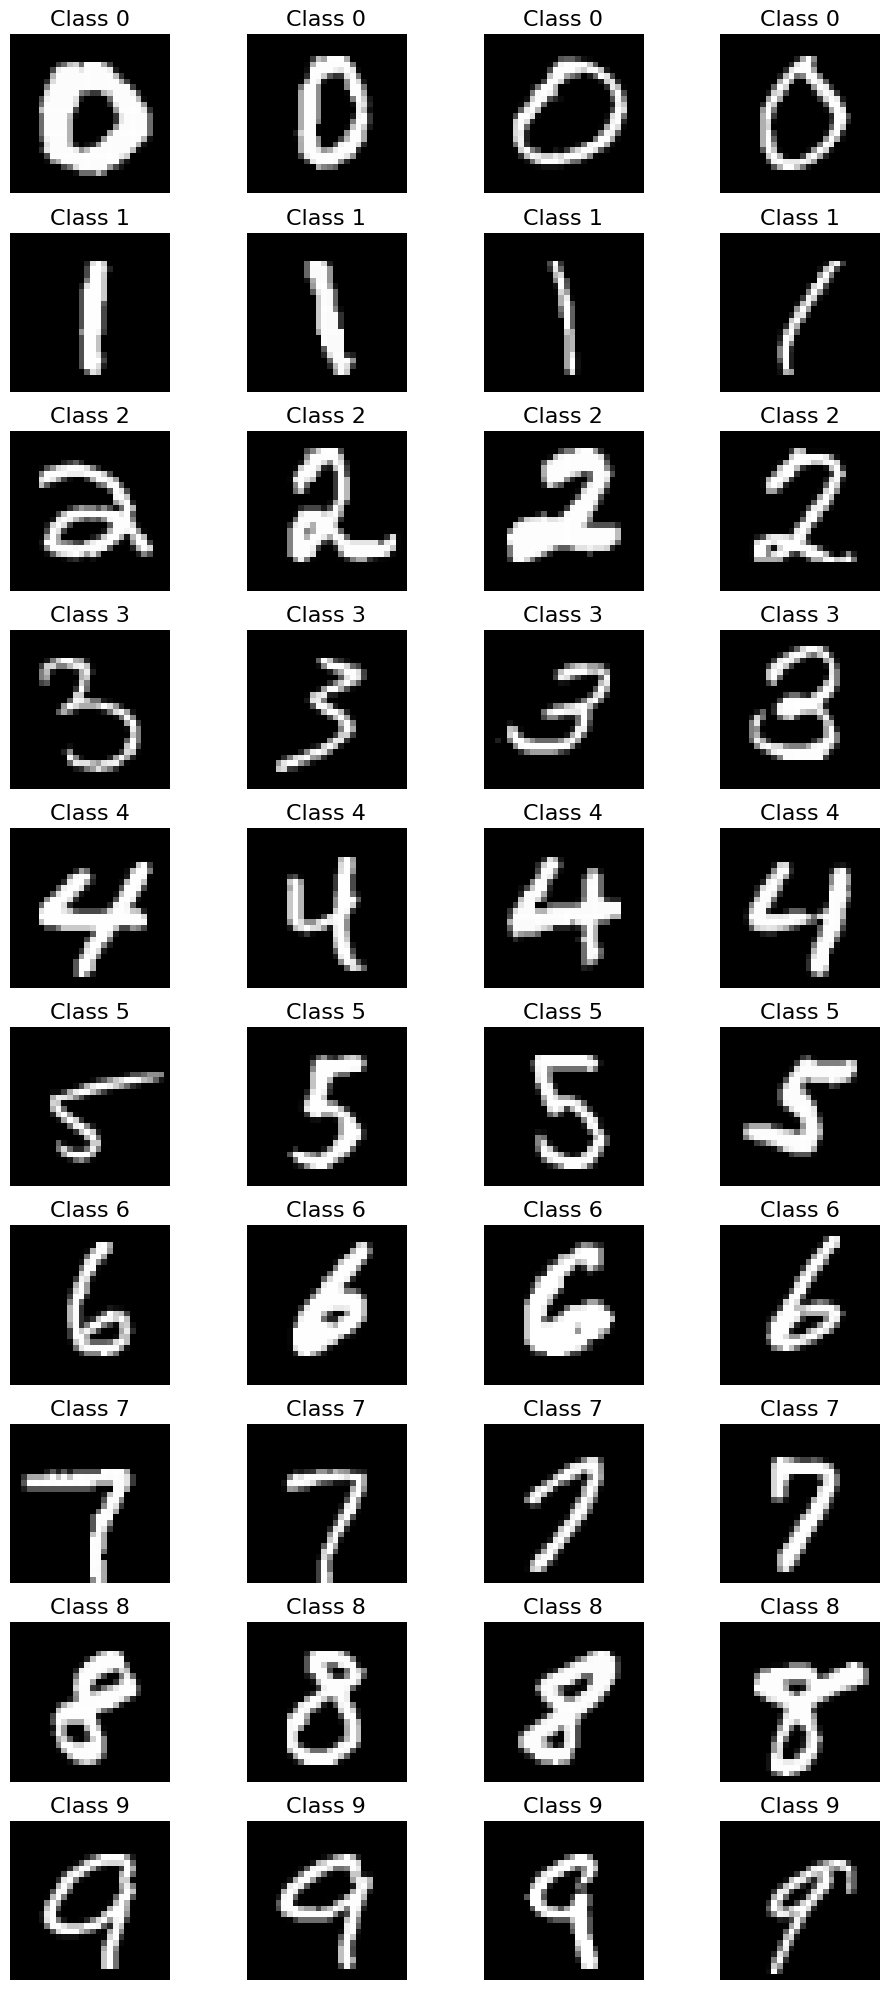

In [46]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

1) VAE --> MLP

In [56]:
class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input

        x = self.encoder(x)

        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        z = self.reparameterize(mu, logvar)

        x_reconstructed = self.decoder(z)

        return x_reconstructed, mu, logvar


In [57]:
def vae_loss(recon, data, mu, logvar):
    # Reconstruction loss using binary cross-entropy
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss as the sum of reconstruction and KL divergence losses
    total_loss = reconstruction_loss + kl_divergence

    return total_loss


In [58]:
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Forward process
            recon, mu, logvar = model(data)

            # Flatten the data and recon tensors
            data = data.view(-1, 784)
            recon = recon.view(-1, 784)

            # Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, logvar)

            # Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, model.decoder[0].in_features)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


In [59]:
# Define the VAE-MLP model
input_dim = 28 * 28  # MNIST image size
hidden_dim = 256
latent_dim = 20
vae_mlp = VAE_MLP(input_dim, hidden_dim, latent_dim)


##################################################
VAE-MLP Epoch [1/10], Loss: 166.99524541829427
Sample Images:


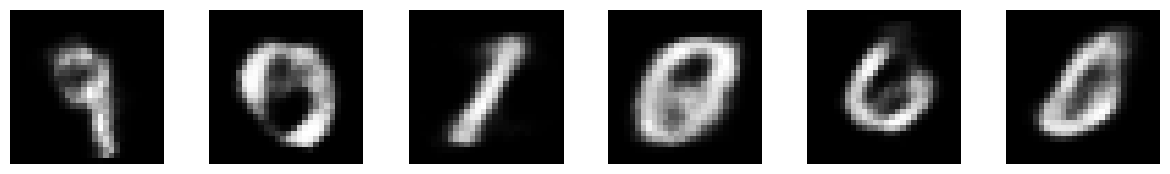


##################################################
VAE-MLP Epoch [2/10], Loss: 125.90047018229167
Sample Images:


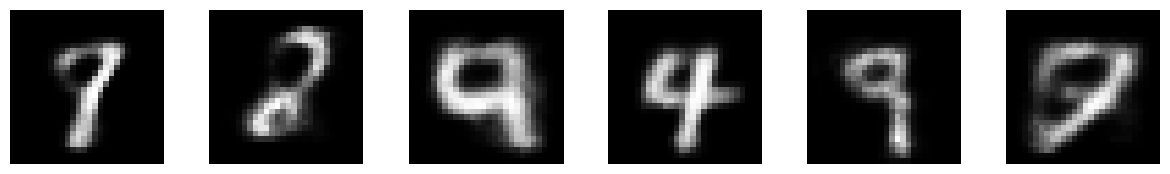


##################################################
VAE-MLP Epoch [3/10], Loss: 116.86056465250651
Sample Images:


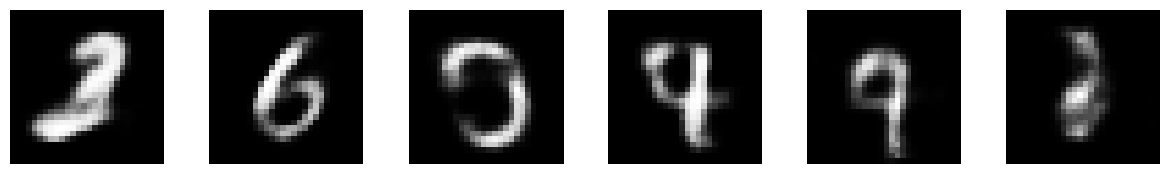


##################################################
VAE-MLP Epoch [4/10], Loss: 112.7001888671875
Sample Images:


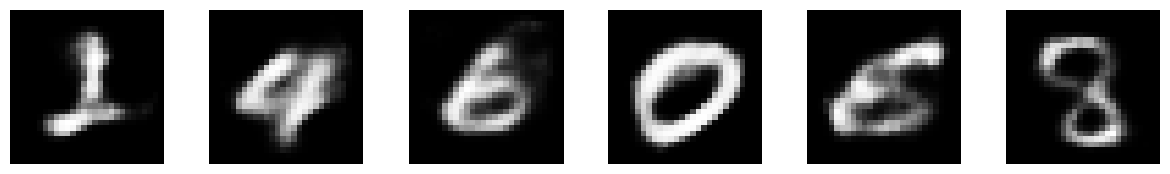


##################################################
VAE-MLP Epoch [5/10], Loss: 110.46744622802734
Sample Images:


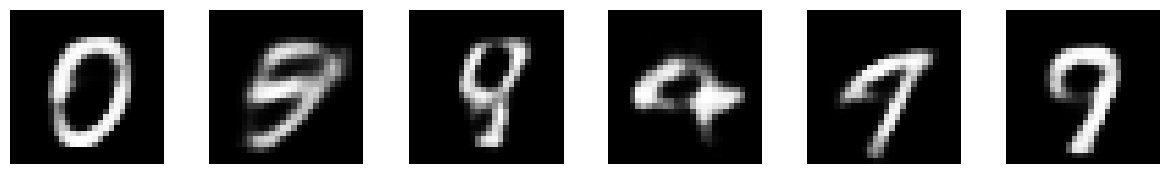


##################################################
VAE-MLP Epoch [6/10], Loss: 108.85899957682291
Sample Images:


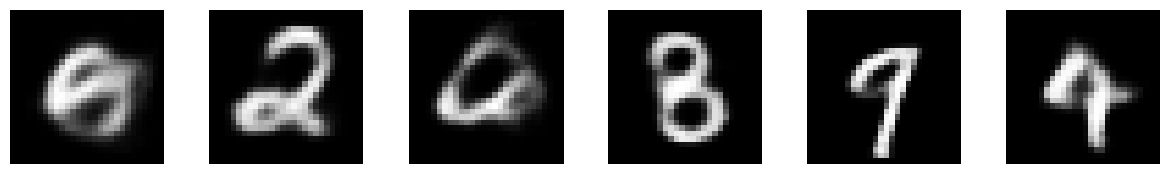


##################################################
VAE-MLP Epoch [7/10], Loss: 107.60429003092447
Sample Images:


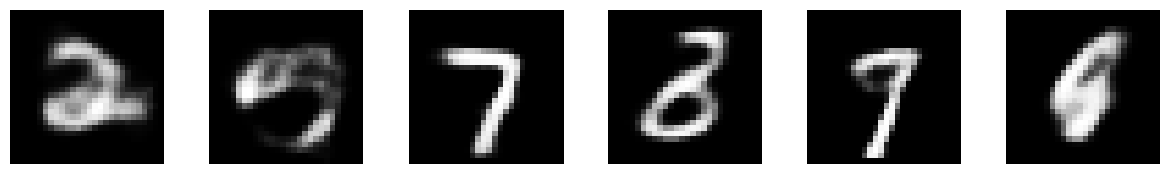


##################################################
VAE-MLP Epoch [8/10], Loss: 106.5665917154948
Sample Images:


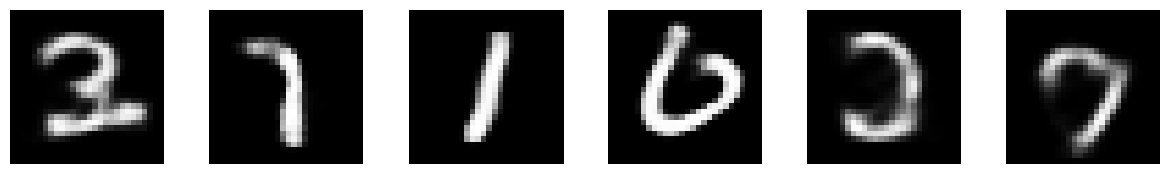


##################################################
VAE-MLP Epoch [9/10], Loss: 105.76002775065105
Sample Images:


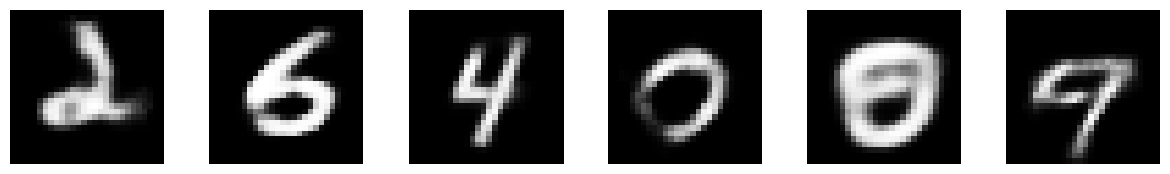


##################################################
VAE-MLP Epoch [10/10], Loss: 105.07017026367187
Sample Images:


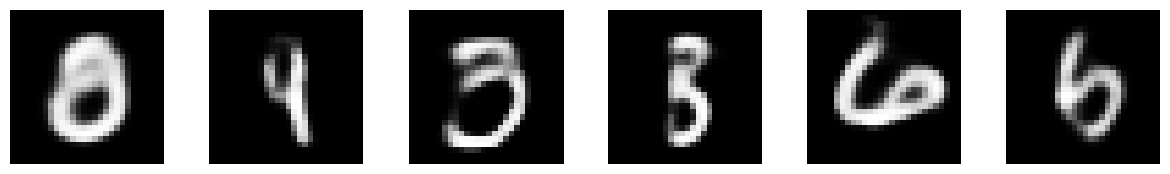

Best model saved as 'best_vae_mlp_model.pth'


In [60]:
# Train VAE-MLP
train_vae_mlp(vae_mlp, train_loader)

CVAE --> MLP

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )

        # Parameters for latent representation
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_class = nn.Linear(hidden_dim, num_classes)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Assuming input is in [0, 1] range (like MNIST)
        )

        self.latent_dim = latent_dim  # Add the latent_dim attribute

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate input and labels for both encoder and decoder
        encoder_input = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(encoder_input)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        class_logits = self.fc_class(hidden)

        # Reparameterization trick
        z = self.reparameterize(mu, logvar)

        # Decoder
        decoder_input = torch.cat([z, y], dim=1)
        reconstructed = self.decoder(decoder_input)

        return reconstructed, mu, logvar, class_logits



In [107]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(-1, recon.size(1))

    # Reconstruction loss (binary cross-entropy)
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')

    # Total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss


In [108]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            # One-hot encode the labels
            num_classes = 10  # Assuming 10 classes for MNIST
            labels_one_hot = F.one_hot(labels, num_classes)

            # Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            # Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader.dataset)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 10
                z = torch.randn(num_samples, model.latent_dim)
                y = F.one_hot(torch.arange(num_samples) % num_classes, num_classes)
                sample = torch.cat([z, y.float()], dim=1)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Sample {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 163.1579040690104
Sample Images:


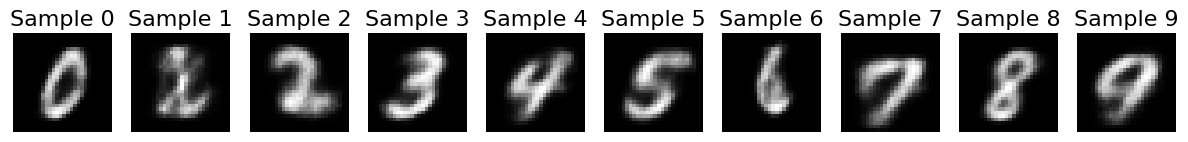


##################################################
CVAE-MLP Epoch [2/10], Loss: 139.0917723388672
Sample Images:


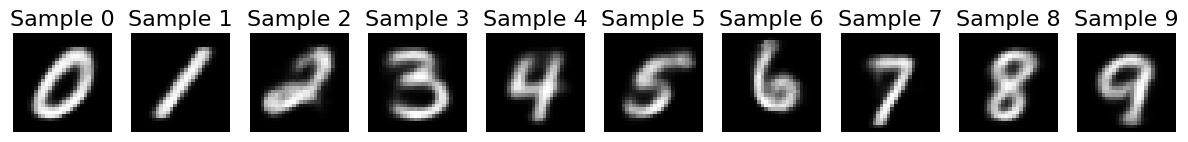


##################################################
CVAE-MLP Epoch [3/10], Loss: 135.44763334960936
Sample Images:


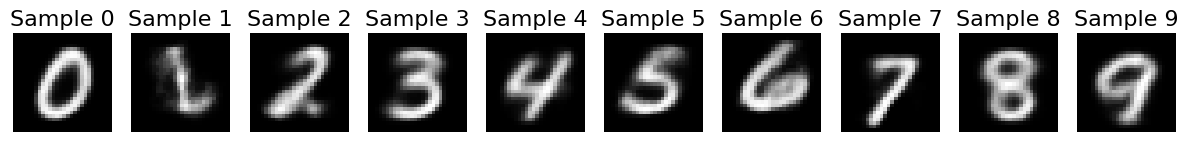


##################################################
CVAE-MLP Epoch [4/10], Loss: 133.73522456054687
Sample Images:


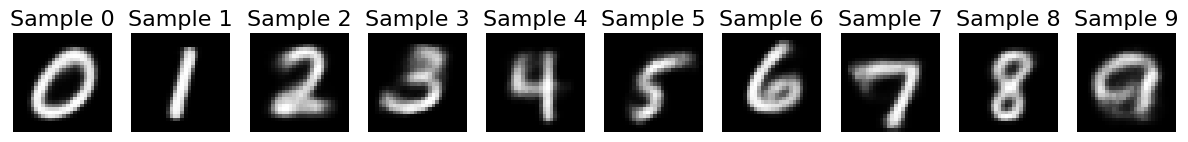


##################################################
CVAE-MLP Epoch [5/10], Loss: 132.5902114095052
Sample Images:


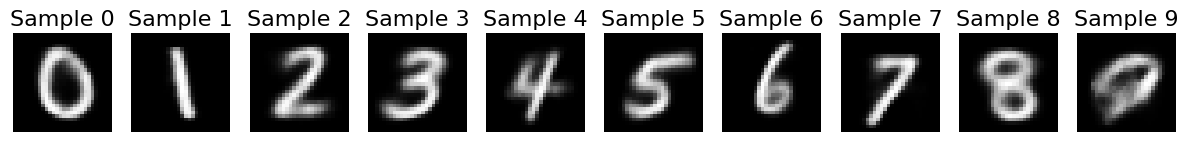


##################################################
CVAE-MLP Epoch [6/10], Loss: 131.81590342610676
Sample Images:


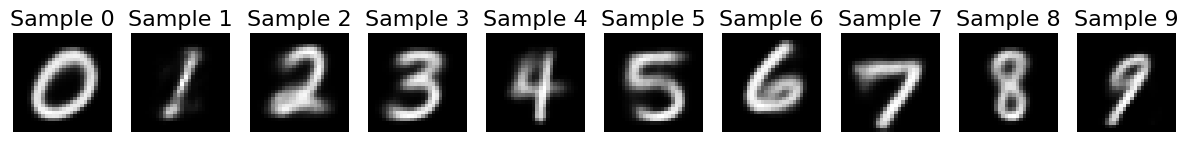


##################################################
CVAE-MLP Epoch [7/10], Loss: 131.22028303222658
Sample Images:


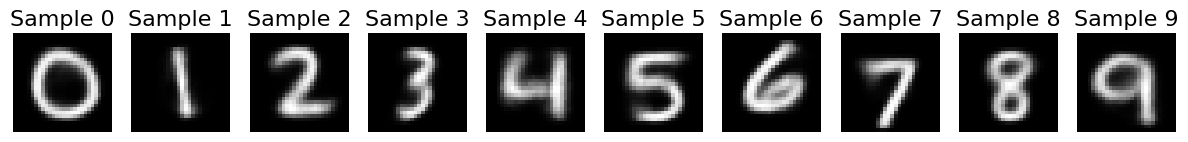


##################################################
CVAE-MLP Epoch [8/10], Loss: 130.75300689697266
Sample Images:


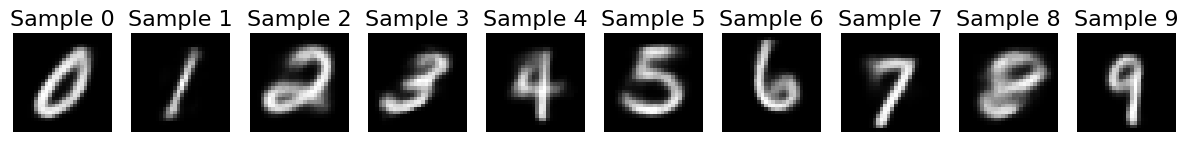


##################################################
CVAE-MLP Epoch [9/10], Loss: 130.40781228841146
Sample Images:


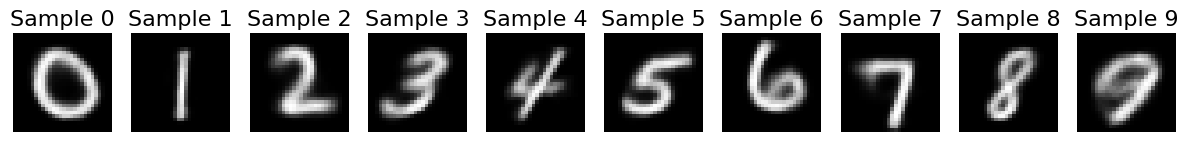


##################################################
CVAE-MLP Epoch [10/10], Loss: 130.04708920898437
Sample Images:


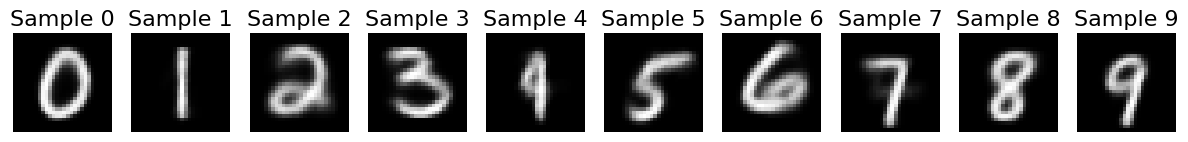

Best model saved as 'best_cvae_mlp_model.pth'


In [109]:
# Define the parameters for your CVAE_MLP model
input_dim = 28 * 28  # Assuming MNIST images
hidden_dim = 256
latent_dim = 2
num_classes = 10  # Assuming 10 classes for MNIST

# Instantiate the CVAE_MLP model
cvae_mlp = CVAE_MLP(input_dim, hidden_dim, latent_dim, num_classes)

# Train the model
train_cvae_mlp(cvae_mlp, train_loader)

3) Visualizing Latent Space Distribution in Two Models

VAE

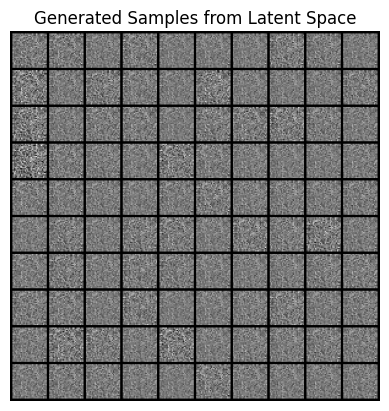

In [124]:
from torchvision.utils import make_grid

# Instantiate the VAE model
vae_model = CVAE_MLP(input_dim=28*28, hidden_dim=256, latent_dim=2, num_classes=10)  # Adjust parameters as needed

# Function to generate and visualize samples from the latent space
def visualize_latent_space(model, num_samples=100):
    with torch.no_grad():
        # Generate random samples in the latent space
        z_samples = torch.randn(num_samples, model.latent_dim)

        # Generate one-hot encoded class labels
        num_classes = 10  # Adjust as needed
        y_samples = torch.eye(num_classes).repeat(num_samples // num_classes, 1)

        # Concatenate the random samples and class labels before passing them to the decoder
        samples = torch.cat([z_samples, y_samples], dim=1)

        # Pass samples through the decoder
        generated_images = model.decoder(samples).view(num_samples, 1, 28, 28)

        # Display the generated images in a grid
        grid = make_grid(generated_images, nrow=int(num_samples**0.5), normalize=True)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title('Generated Samples from Latent Space')
        plt.axis('off')
        plt.show()

# Visualize the latent space distribution
visualize_latent_space(vae_model, num_samples=100)


CVAE

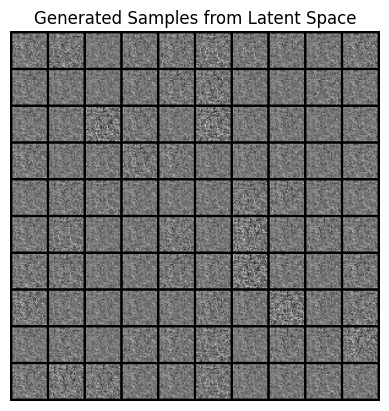

In [125]:
from torchvision.utils import make_grid

# Instantiate the CVAE model
cvae_model = CVAE_MLP(input_dim=28*28, hidden_dim=256, latent_dim=2, num_classes=10)  # Adjust parameters as needed

# Function to generate and visualize samples from the latent space
def visualize_latent_space(model, num_samples=100):
    with torch.no_grad():
        # Generate random samples in the latent space
        z_samples = torch.randn(num_samples, model.latent_dim)

        # Generate one-hot encoded class labels
        num_classes = 10  # Adjust as needed
        y_samples = torch.eye(num_classes).repeat(num_samples // num_classes, 1)

        # Concatenate the random samples and class labels before passing them to the decoder
        samples = torch.cat([z_samples, y_samples], dim=1)

        # Pass samples through the decoder
        generated_images = model.decoder(samples).view(num_samples, 1, 28, 28)

        # Display the generated images in a grid
        grid = make_grid(generated_images, nrow=int(num_samples**0.5), normalize=True)
        plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
        plt.title('Generated Samples from Latent Space')
        plt.axis('off')
        plt.show()

# Visualize the latent space distribution
visualize_latent_space(cvae_model, num_samples=100)


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).(PDF)